In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
true_temp_df = pd.read_csv("csv_files/weather.csv", usecols=['temp', 'dt', 'today'], dtype={'dt': 'int64'})
forecast_temp_df = pd.read_csv("csv_files/forecast.csv", usecols=['temp', 'dt', 'today'], dtype={'dt': 'int64'})
temp_data_df = pd.read_csv("csv_files/temp_data.csv", usecols=['temp', 'dt', 'today', 't5', 't4', 't3', 't2', 't1'])
metrics_df = pd.read_csv("csv_files/metrics.csv")

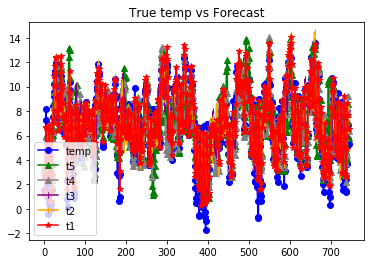

In [17]:
N = temp_data_df.shape[0]
x = np.linspace(0,N,N)
plt.plot(x, temp_data_df['temp'], label='temp', color='blue', marker='o')
plt.plot(x, temp_data_df['t5'], label='t5', color='green', marker='^')
plt.plot(x, temp_data_df['t4'], label='t4', color='grey', marker='^')
plt.plot(x, temp_data_df['t3'], label='t3', color='purple', marker='|')
plt.plot(x, temp_data_df['t2'], label='t2', color='orange', marker='|')
plt.plot(x, temp_data_df['t1'], label='t1', color='red', marker='*')
plt.title("True temp vs Forecast")
plt.legend()
plt.show()

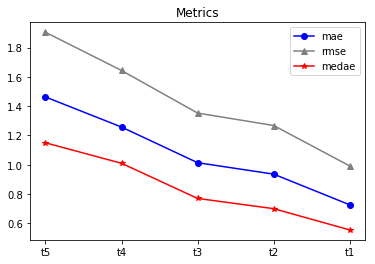

In [18]:
x = np.linspace(0,1,5)
axes= plt.axes()
axes.set_xticks(x)
axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
plt.plot(x, metrics_df['mae'], label='mae', color='blue', marker='o')
plt.plot(x, metrics_df['rmse'], label='rmse', color='grey', marker='^')
plt.plot(x, metrics_df['medae'], label='medae', color='red', marker='*')
plt.title("Metrics")
plt.legend()
plt.show()

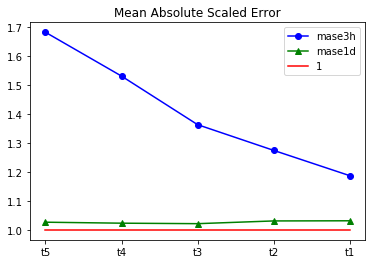

In [19]:
x = np.linspace(0,1,5)
axes= plt.axes()
axes.set_xticks(x)
axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
plt.plot(x, metrics_df['mase'], label='mase3h', color='blue', marker='o')
plt.plot(x, metrics_df['mase1d'], label='mase1d', color='green', marker='^')
plt.plot(x, np.ones(5), label='1', color='red')
plt.title("Mean Absolute Scaled Error")
plt.legend()
plt.show()

In [20]:
true_temp_df.describe()

,temp,dt
count,783.000000,7.830000e+02
mean,6.648033,1.579133e+09
std,2.983036,2.442711e+06
min,-1.720000,1.574910e+09
25%,4.885000,1.577021e+09
50%,6.870000,1.579133e+09
75%,8.830000,1.581244e+09
max,13.540000,1.583356e+09


In [21]:
true_temp_df

,temp,dt,today
0,8.19,1574910000,2019-11-28
1,8.19,1574920800,2019-11-28
2,7.93,1574931600,2019-11-28
3,9.36,1574942400,2019-11-28
4,9.32,1574953200,2019-11-28
5,8.54,1574964000,2019-11-28
6,7.31,1574974800,2019-11-28
7,6.23,1574985600,2019-11-29
8,5.33,1574996400,2019-11-29
9,3.65,1575007200,2019-11-29


In [22]:
true_temp_df['today'].unique()

array(['2019-11-28', '2019-11-29', '2019-11-30', '2019-12-01',
       '2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05',
       '2019-12-06', '2019-12-07', '2019-12-08', '2019-12-09',
       '2019-12-10', '2019-12-11', '2019-12-12', '2019-12-13',
       '2019-12-14', '2019-12-15', '2019-12-16', '2019-12-17',
       '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-21',
       '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
       '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
       '2019-12-30', '2019-12-31', '2020-01-01', '2020-01-02',
       '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06',
       '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
       '2020-01-11', '2020-01-12', '2020-01-13', '2020-01-14',
       '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18',
       '2020-01-19', '2020-01-20', '2020-01-21', '2020-01-22',
       '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
       '2020-01-27', '2020-01-28', '2020-01-29', '2020-

In [23]:
true_temp_df.iloc[::8]

,temp,dt,today
0,8.19,1574910000,2019-11-28
8,5.33,1574996400,2019-11-29
16,-0.88,1575082800,2019-11-30
24,2.57,1575169200,2019-12-01
32,0.06,1575255600,2019-12-02
40,1.38,1575342000,2019-12-03
48,0.86,1575428400,2019-12-04
56,0.01,1575514800,2019-12-05
64,10.23,1575601200,2019-12-06
72,8.49,1575687600,2019-12-07


In [24]:
london_historical_df = pd.read_csv("london_weather_historical_data.csv")

In [25]:
london_historical_df.head()

,dt,dt_iso,timezone,city_id,city_name,lat,lon,temp,temp_min,temp_max,...,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,946684800,2000-01-01 00:00:00 +0000 UTC,0,2643743,London,51.50853,-0.12574,7.18,6.5,7.6,...,NaN,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
1,946688400,2000-01-01 01:00:00 +0000 UTC,0,2643743,London,51.50853,-0.12574,7.35,6.9,7.6,...,NaN,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
2,946692000,2000-01-01 02:00:00 +0000 UTC,0,2643743,London,51.50853,-0.12574,8.06,7.3,9.0,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
3,946695600,2000-01-01 03:00:00 +0000 UTC,0,2643743,London,51.50853,-0.12574,8.26,7.4,9.1,...,NaN,NaN,NaN,NaN,NaN,90,721,Haze,haze,50n
4,946699200,2000-01-01 04:00:00 +0000 UTC,0,2643743,London,51.50853,-0.12574,8.52,7.9,9.2,...,NaN,NaN,NaN,NaN,NaN,90,721,Haze,haze,50n


In [26]:
london_historical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174938 entries, 0 to 174937
Data columns (total 33 columns):
dt                     174938 non-null int64
dt_iso                 174938 non-null object
timezone               174938 non-null int64
city_id                174938 non-null int64
city_name              174938 non-null object
lat                    174938 non-null float64
lon                    174938 non-null float64
temp                   174938 non-null float64
temp_min               174938 non-null float64
temp_max               174938 non-null float64
pressure               174938 non-null float64
sea_level              0 non-null float64
grnd_level             0 non-null float64
humidity               174938 non-null int64
wind_speed             174938 non-null float64
wind_deg               174938 non-null int64
rain_1h                6416 non-null float64
rain_3h                1 non-null float64
rain_6h                13331 non-null float64
rain_12h               116

In [27]:
london_historical_df[['dt_iso','temp']].head()

,dt_iso,temp
0,2000-01-01 00:00:00 +0000 UTC,7.18
1,2000-01-01 01:00:00 +0000 UTC,7.35
2,2000-01-01 02:00:00 +0000 UTC,8.06
3,2000-01-01 03:00:00 +0000 UTC,8.26
4,2000-01-01 04:00:00 +0000 UTC,8.52


In [28]:
london_historical_df[['dt','dt_iso','temp']].tail()

,dt,dt_iso,temp
174933,1576177200,2019-12-12 19:00:00 +0000 UTC,7.79
174934,1576180800,2019-12-12 20:00:00 +0000 UTC,7.64
174935,1576184400,2019-12-12 21:00:00 +0000 UTC,7.58
174936,1576188000,2019-12-12 22:00:00 +0000 UTC,7.40
174937,1576191600,2019-12-12 23:00:00 +0000 UTC,7.43
